<a href="https://colab.research.google.com/github/sayakpaul/Phishing-Websites-Detection/blob/master/Experimentation_with_validation_splits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook builds on top of [this notebook](github/sayakpaul/Phishing-Websites-Detection/blob/master/Phishing_Websites%27_Detection_with_Neural_Networks_using_fastai.ipynb) and[ this notebook](github/sayakpaul/Phishing-Websites-Detection/blob/master/Detecting%20Phishing%20Websites%20using%20Neural%20Networks.ipynb). Hence, I will not be describing anything about the dataset in much detail. The aim of this notebook is to experiment between random split and a split with respect to indices. 

We will use the  `random_split_by_pct()` and `split_by_idx()` helper functions provided by `fastai`. 

### Imports and magics

In [0]:
# Filter the uneccesary warnings
import warnings
warnings.filterwarnings("ignore")

# Import pandas and numpy
import pandas as pd
import numpy as np

# Fix the random seed
np.random.seed(7)

from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

### Dataset loading and class distribution

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/sayakpaul/Phishing-Websites-Detection/master/Phishing.csv')

classes = Counter(data['Result'].values)
class_dist = pd.DataFrame(classes.most_common(), columns=['Class', 'Num_Observations'])
class_dist

,Class,Num_Observations
0,1,6157
1,-1,4898


### Renaming, mapping and type-casting

In [0]:
data.rename(columns={'Result': 'Class'}, inplace=True)

data['Class'] = data['Class'].map({-1:0, 1:1})

for col in data.columns:
    data[col] = data[col].astype('category')

In [0]:
# Save the dataset temporarily
!mkdir data
data.to_csv('data/Phishing.csv', index=False)

### Importing `fastai` and preapring the `TabularDataBunch` with random splitting

In [0]:
from fastai.tabular import * 

procs = [Categorify]
dep_var = 'Class'
cat_names = data.columns[:-1]


path = Path('content/data')

databunch = (TabularList.from_df(data, path=path, cat_names=cat_names, procs=procs)
                  .random_split_by_pct(valid_pct=0.2, seed=np.random.seed(7))
                  .label_from_df(cols=dep_var)
                  .databunch())

### Categorical vairables of the databunch and split details

In [0]:
databunch.train_ds.cat_names

Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report'],
      dtype='object')


In [0]:
databunch.label_list

LabelLists;

Train: LabelList (8844 items)
x: TabularList
having_IP_Address 1; URL_Length 1; Shortining_Service 1; having_At_Symbol 1; double_slash_redirecting 1; Prefix_Suffix -1; having_Sub_Domain 0; SSLfinal_State 1; Domain_registeration_length -1; Favicon 1; port 1; HTTPS_token -1; Request_URL 1; URL_of_Anchor 0; Links_in_tags -1; SFH -1; Submitting_to_email 1; Abnormal_URL 1; Redirect 0; on_mouseover 1; RightClick 1; popUpWidnow 1; Iframe 1; age_of_domain -1; DNSRecord -1; web_traffic 0; Page_Rank -1; Google_Index 1; Links_pointing_to_page 1; Statistical_report 1; ,having_IP_Address 1; URL_Length 0; Shortining_Service 1; having_At_Symbol 1; double_slash_redirecting 1; Prefix_Suffix -1; having_Sub_Domain -1; SSLfinal_State -1; Domain_registeration_length -1; Favicon 1; port 1; HTTPS_token -1; Request_URL 1; URL_of_Anchor 0; Links_in_tags -1; SFH -1; Submitting_to_email -1; Abnormal_URL -1; Redirect 0; on_mouseover 1; RightClick 1; popUpWidnow 1; Iframe 1; age_of_domain 1; DNSRecord

### Training a basic model with entity embedding and 1cycle policy

In [6]:
learn = tabular_learner(databunch, layers=[200,100], metrics=accuracy)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.222418,0.137602,0.947083,00:02
1,0.168855,0.131224,0.944369,00:02
2,0.151120,0.118204,0.946178,00:02
3,0.136186,0.109984,0.954319,00:02
4,0.123933,0.136637,0.939846,00:02
5,0.114465,0.095191,0.963365,00:02
6,0.114802,0.090595,0.963817,00:02
7,0.093888,0.094725,0.959747,00:02
8,0.077647,0.083364,0.966079,00:02
9,0.079316,0.083269,0.966531,00:02


### Model's losses

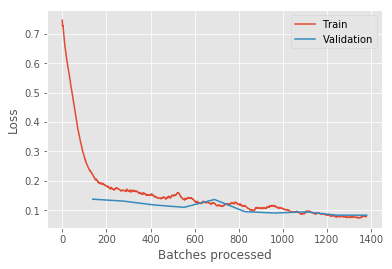

In [7]:
learn.recorder.plot_losses()

### Finding an optimal learning rate for the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


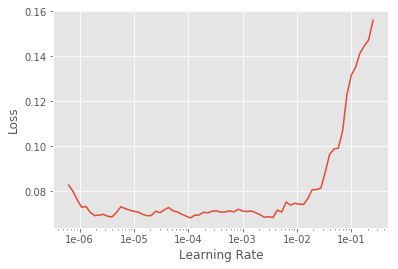

In [8]:
learn.lr_find()
learn.recorder.plot()

### Using the initial weights and a learning rate of `0.75*1e-05`

In [9]:
learn.load('tmp')
learn.fit_one_cycle(5, 0.75*1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.074613,0.080322,0.969697,00:02
1,0.083885,0.090511,0.962913,00:02
2,0.078624,0.080654,0.967888,00:02
3,0.074189,0.081204,0.966531,00:02
4,0.068620,0.080812,0.967888,00:02


In [0]:
# Saving model state
learn.save('stage-1')

### Retraining using the previous weights and a bit of weight decay

In [11]:
learn.load('stage-1')
learn.fit_one_cycle(5, slice(1e-03), 0.025)

epoch,train_loss,valid_loss,accuracy,time
0,0.068156,0.084769,0.964722,00:02
1,0.079547,0.086404,0.967888,00:02
2,0.068765,0.077622,0.967436,00:02
3,0.064083,0.076942,0.966079,00:02
4,0.057128,0.074585,0.970602,00:02


**A much better score!**

In [0]:
learn.save('stage-2')

### Confusion matrix of the model

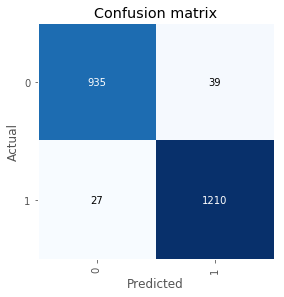

In [41]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

### Now with a non-random split

Using a fixed set of validation samples might not be a good idea for this problem. 

In [0]:
non_random_databunch = (TabularList.from_df(data, path=path, cat_names=cat_names, procs=procs)
                  .split_by_idx(valid_idx = range(len(data)-2211, len(data)))
                  .label_from_df(cols=dep_var)
                  .databunch())

### Everything else what follows from here is same as the above

In [27]:
learn = tabular_learner(non_random_databunch, layers=[200,100], metrics=accuracy)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.218769,0.200361,0.914971,00:01
1,0.159979,0.179134,0.919493,00:02
2,0.152013,0.214131,0.916780,00:02
3,0.135683,0.193577,0.918137,00:02
4,0.125174,0.177936,0.925825,00:02
5,0.120260,0.140550,0.939846,00:02
6,0.104981,0.156985,0.927182,00:02
7,0.088442,0.152789,0.937585,00:02
8,0.077883,0.157934,0.934871,00:02
9,0.074149,0.158337,0.934871,00:02


In [0]:
learn.save('stage-2-non-random')

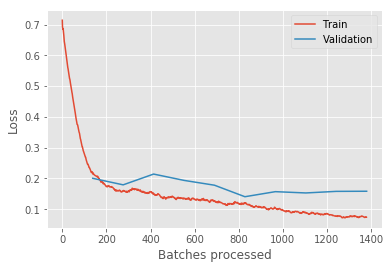

In [29]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


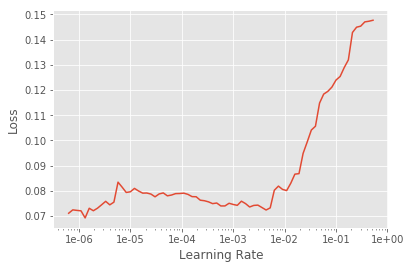

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.load('stage-2-non-random')
learn.fit_one_cycle(5, 1e-04)

epoch,train_loss,valid_loss,accuracy,time
0,0.066610,0.159552,0.933967,00:02
1,0.071841,0.157673,0.933514,00:02
2,0.073377,0.163385,0.933062,00:02
3,0.073682,0.159165,0.934419,00:02
4,0.071067,0.157128,0.932157,00:02


In [0]:
learn.save('stage-3-non-random')

In [35]:
learn.load('stage-3-non-random')
learn.fit_one_cycle(5, slice(1e-04), 0.025)

epoch,train_loss,valid_loss,accuracy,time
0,0.070018,0.160826,0.934419,00:02
1,0.069421,0.154737,0.935776,00:02
2,0.072288,0.159307,0.933062,00:02
3,0.069989,0.155310,0.933062,00:02
4,0.067183,0.154376,0.935323,00:02


**The difference between the score is clear.**